/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/plat

['Adriano1', 'Adriano2', 'Adriano3', 'AleaJactaEst', 'AntonioPulcherio', 'AraraClayton', 'Arthur', 'Arthur2', 'Cascalho', 'Cecilia1', 'Cecilia2', 'CorreVento', 'Daniel', 'Eliane', 'Eliane2', 'Fernanda', 'FlavioCCoelho', 'FlavioCoelho', 'Gabriel', 'Gabrielp']
FlavioCCoelho Morreu na rodada 27 com -28.0 pontos
Restam 19 jogadores
Eliane2 Morreu na rodada 30 com -21.0 pontos
Restam 18 jogadores
Iniciando Rodada 50
AleaJactaEst Morreu na rodada 57 com -9.0 pontos
Restam 17 jogadores
Gabrielp Morreu na rodada 60 com -14.0 pontos
Restam 16 jogadores
Gabriel Morreu na rodada 65 com -9.0 pontos
Restam 15 jogadores
Cecilia1 Morreu na rodada 75 com -17.0 pontos
Restam 14 jogadores
FlavioCoelho Morreu na rodada 90 com -6.0 pontos
Restam 13 jogadores
Iniciando Rodada 100
Daniel Morreu na rodada 130 com -14.0 pontos
Restam 12 jogadores
Iniciando Rodada 150
Eliane Morreu na rodada 153 com -2.0 pontos
Restam 11 jogadores
Adriano3 Morreu na rodada 190 com -6.0 pontos
Restam 10 jogadores
Adriano2 Morre

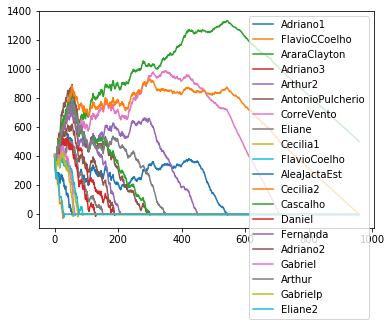

<Figure size 432x288 with 0 Axes>

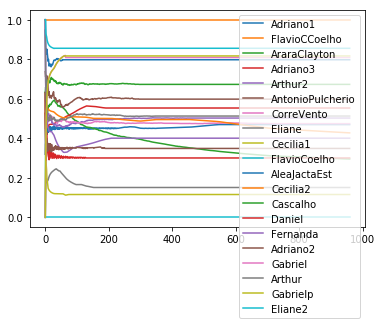

In [4]:
#!/usr/bin/env python3
# coding: utf8
__author__ = 'fccoelho'

import pkgutil
import importlib
import logging
import traceback
from collections import defaultdict
import random
import copy
import os
import numpy as np
import pandas as pd
from liveplots.xmlrpcserver import rpc_plot
import xmlrpc.client
import matplotlib
import matplotlib.pyplot as P
matplotlib.use ('Agg')


jogadores = [name for _,name,_ in pkgutil.iter_modules(['estrategias'])]
jogadores.remove('jogadores')
print(jogadores)



class Torneio(object):
    def __init__(self):
        self.historico = defaultdict(lambda: {"comida": [], "reputacao": [], "cacou": 0, "descansou": 0})
        self.jogadores = None # dicionario com as instancias dos jogadores;
        self.recompensa = []
        self.cemiterio = {}
        self.rodada = 0
        self.bugados = {}
        self.M = [] #série de m
        self.comida_plot = xmlrpc.client.ServerProxy('http://localhost:{}'.format(rpc_plot(persist=1)))
        self.recompensa_plot = xmlrpc.client.ServerProxy('http://localhost:{}'.format(rpc_plot(persist=1)))



    @property
    def p(self):
        if self.jogadores is None:
            return 0
        return len(self.jogadores)

    def inicializa_jogadores(self, comida=300.0):
        self.jogadores = {x : importlib.import_module("estrategias.{}".format(x)).MeuJogador() for x in jogadores}
        for nome, jogador in self.jogadores.items():
            self.historico[nome]["comida"].append(comida*(self.p-1))
            self.historico[nome]["reputacao"].append(0.)
        self.inicializa_saida()

    def inicializa_saida(self):
        mode = "w"
        cabecalho = ','.join(self.historico.keys()) + '\n'
        with open("comida.csv", mode) as f:
            f.write(cabecalho)
        with open("reputacao.csv", mode) as f:
            f.write(cabecalho)
        with open("recompensa.csv", mode) as f:
            f.write("recompensa")

    def roda_rodada(self):
        """
        Coleta as escolhas de cada jogador

        """
        self.rodada += 1
        if self.rodada%50 == 0:
            print("Iniciando Rodada {}".format(self.rodada))
        jogadores_randomizados = [jog for jog in self.jogadores.keys() if jog not in self.bugados]
        random.shuffle(jogadores_randomizados)
        m = random.randrange(0, self.p*(self.p-1))
        self.M.append(m)
        escolhas = {}
        
        for nome in jogadores_randomizados:
            jogador = self.jogadores[nome]
            adversarios = copy.copy(jogadores_randomizados)
            adversarios.remove(nome)
            reputacoes = tuple([self.historico[nome_adv]["reputacao"][-1] for nome_adv in adversarios])
            try:
                escolhas[nome] = (jogador.escolha_de_cacada(self.rodada, self.historico[nome]["comida"][-1],
                                      self.historico[nome]["reputacao"][-1],
                                      m, reputacoes), tuple(adversarios))
            except Exception as e:
                #logging.error(traceback.format_exc())
                #print(e.__doc__)
                #print(e.message)
                escolhas[nome] = (['c' for i in reputacoes], adversarios)
                self.bugados[nome] = (self.rodada, e)
                self.cemiterio[nome] = self.rodada
                
            self.historico[nome]["cacou"] += sum([e == 'c' for e in escolhas[nome][0]])
            self.historico[nome]["descansou"] += sum([e == 'd' for e in escolhas[nome][0]])
        saldo = self.calcula_resultado_cacadas(escolhas)
        recompensa, cacadas = self.calcula_recompensa(escolhas)
        
        R.write(str(recompensa) + "\n")
        for nome, jogador in self.jogadores.items():
            jogador.resultado_da_cacada(saldo)
            jogador.fim_da_rodada(recompensa, self.M[-1], cacadas)
        self.atualiza_reputacao()
        self.atualiza_comida(saldo, recompensa)
        #==== Monitor the situation
        self.monitor()
        #=============
        for nome in self.bugados.keys():
            if nome in self.cemiterio:
                continue
            # self.enterra(nome)
            print("{} Morreu bugado, na rodada {}. Erro: {}".format(nome, self.rodada, self.bugados[nome]))

    def monitor(self, fim=False):
        """
        Plot simulation status using liveplots
        :return:
        """
        window_size = 2000
        if self.rodada % 1000 == 0 or fim:
            com_series = [self.historico[nome]["comida"][-window_size:] for nome in jogadores] #if nome not in self.cemiterio]
            jogs = [j for j in jogadores ]#if j not in self.cemiterio]
            xmin = self.rodada-window_size if self.rodada >= window_size else 0
            xmax = self.rodada+window_size if self.rodada >= window_size else self.rodada
            xs = list(range(xmin, xmax))
            self.comida_plot.lines(com_series, xs, jogs, "Comida por Jogador", 'lines', 0)
            self.recompensa_plot.lines([self.recompensa[-window_size:]], xs, ['recompensa'], "recompensa", 'lines', 0)

    def calcula_resultado_cacadas(self, escolhas):
        """
        Calcula comida obtida em todas as caçadas e retorna o saldo por jogador

        :rtype : defaultdict
        :param escolhas:
        :return:
        """
        saldo = defaultdict(lambda: [])  # saldo de todos as cacadas por jogador
        cooperadores = []
        for nome_jogador, cacadas in escolhas.items():
            for decisao, adversario in zip(*cacadas):
                gasto = -2 if decisao == 'd' else -6
                ganho_pessoal = 6 if decisao == 'c' else 0
                #print len(escolhas[adversario][0]), tuple(escolhas[adversario][1]).index(nome_jogador)
                adversario_cooperou = escolhas[adversario][0][tuple(escolhas[adversario][1]).index(nome_jogador)] == 'c'
                ganho_adversario = 6 if adversario_cooperou else 0
                saldo[nome_jogador].append(gasto + (ganho_pessoal+ganho_adversario)/2.)
            self.jogadores[nome_jogador].resultado_da_cacada(saldo[nome_jogador])
        return saldo

    def atualiza_comida(self, saldo, recompensa):
        jogadores = copy.deepcopy(self.jogadores)
        for nome in jogadores:
            comida = saldo[nome]
            if nome in self.cemiterio:
                # print("{} está morto, zerando a comida!!".format(nome))
                self.historico[nome]["comida"].append(0.0)
            else:
                comida_atual = float(self.historico[nome]["comida"][-1])
                self.historico[nome]["comida"].append(float(comida_atual + sum(comida) + recompensa))
            if self.historico[nome]["comida"][-1] <= 0:
                self.enterra(nome, self.historico[nome]["comida"][-1])
        #  Feed the dead to keep series of equal length
        for nome in self.cemiterio:
            if nome in jogadores:
                continue
            self.historico[nome]["comida"].append(0.0)

    def atualiza_reputacao(self):
        for nome in self.jogadores.keys():
            self.historico[nome]["reputacao"].append(self.historico[nome]["cacou"] / (float(self.historico[nome]["cacou"] + self.historico[nome]["descansou"])))

    def enterra(self, nome, comida=0):
        del self.jogadores[nome]
        # self.historico[nome]["comida"].append(0.0) # Add an extra food item to maintain equal numbers of items
        self.cemiterio[nome] = self.rodada
        print("{} Morreu na rodada {} com {} pontos".format(nome, self.rodada, comida))
        print("Restam {} jogadores".format(len(self.jogadores)))

    def calcula_recompensa(self, escolhas):
        cacadas = 0
        for e in escolhas.items():
            cacadas += sum([i == 'c' for i in e[1][0]]) # number of times this player has hunted
        recompensa = 2*(self.p - 1) if cacadas > self.M[-1] else 0
        self.recompensa.append(recompensa)
        return recompensa, cacadas

    def checa_fim(self):
        if len(self.jogadores) <= 1:
            return True
        return False

    def vai(self, max_rodadas=10000):
        f = open("comida.csv", "a")
        g = open("reputacao.csv", "a")
        while True:
            self.roda_rodada()
            self.salva_series(f,g)
            if self.checa_fim():
                self.anuncia_vencedor()
                break
            elif self.rodada > max_rodadas:
                for nome in self.historico.keys():
                    print (nome, self.historico[nome]["comida"][-1], self.historico[nome]["reputacao"][-1])
                self.anuncia_vencedor()
                break
        f.close()
        g.close()

    def anuncia_vencedor(self):
        self.monitor(fim=True)
        ranking1 = [(nome, data["comida"][-1]) for nome,data in self.historico.items() if (data["comida"][-1]>0 and nome not in self.cemiterio and nome not in self.bugados)]
        ranking = sorted(ranking1, key=lambda x: x[1], reverse=True)
        print ("Sobreviventes:")
        print (ranking)
        if len(ranking1) >=3:
            print ("==> Em Terceiro lugar...: {} com {}".format(ranking[2][0], ranking[2][1]))
            print ("==> Em Segundo lugar...: {} com {}".format(ranking[1][0], ranking[1][1]))
            print ("==> Em Primeiro lugar...: {} com {}".format(ranking[0][0], ranking[0][1]))
        else:
            print ("==> Em Primeiro lugar e único sobrevivente:... {} com {}".format(ranking[0][0], ranking[0][1]))
        print ("Falecidos:")
        print(self.cemiterio)
        print ("Banidos (bugados):")
        print(self.bugados)
        # self.comida_plot.close_plot()
        # self.recompensa_plot.close_plot()

    def salva_series(self, f, g):
        
        comida_t = []
        reputacao_t = []
        for j in self.historico.values():
            comida_t.append(str(j["comida"][-1]))
            reputacao_t.append(str(j["reputacao"][-1]))
        f.write(",".join(comida_t) + "\n")
        g.write(",".join(reputacao_t) + "\n")
        
        
    def plota_series(self):
        comida = pd.read_csv('comida.csv')
        reputacao = pd.read_csv('reputacao.csv')
        comida.plot()
        P.figure()
        reputacao.plot()

if __name__ == "__main__":
    T = Torneio()
    T.inicializa_jogadores(comida=20.0)
    R = open("recompensa.csv", "a")
    T.vai(max_rodadas=2000)
    R.close()
    T.plota_series()
    P.show()